In [76]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting

import re # regular expressions

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size


In [58]:
df = pd.read_csv('../data/clean_train.csv')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436572 entries, 0 to 1436571
Data columns (total 19 columns):
Unnamed: 0             1436572 non-null int64
id                     1436572 non-null object
vendor_id              1436572 non-null int64
pickup_datetime        1436572 non-null object
dropoff_datetime       1436572 non-null object
passenger_count        1436572 non-null int64
pickup_longitude       1436572 non-null float64
pickup_latitude        1436572 non-null float64
dropoff_longitude      1436572 non-null float64
dropoff_latitude       1436572 non-null float64
store_and_fwd_flag     1436572 non-null int64
trip_duration          1436572 non-null int64
pickup_date            1436572 non-null object
date                   1436572 non-null object
minimum temperature    1436572 non-null int64
precipitation          1436572 non-null float64
snow fall              1436572 non-null float64
snow depth             1436572 non-null float64
log_trip_duration      1436572 non-null 

In [60]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)

In [61]:
df =  df.drop(['Unnamed: 0', 'pickup_date'], 1)

In [62]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,minimum temperature,precipitation,snow fall,snow depth,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016-03-14,40,0.29,0.0,0.0,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016-06-12,37,0.35,0.0,0.0,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016-01-19,16,0.00,0.0,0.0,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2016-04-06,66,0.40,0.0,0.0,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,2016-03-26,38,0.00,0.0,0.0,6.077642


First, a scatter plot of the rides throughout the geolocation coordinates shows a rough map of New York City. We can see a concentration of rides going to JFK and La Guardia airports away from the central hub of rides that is in Manhattan.

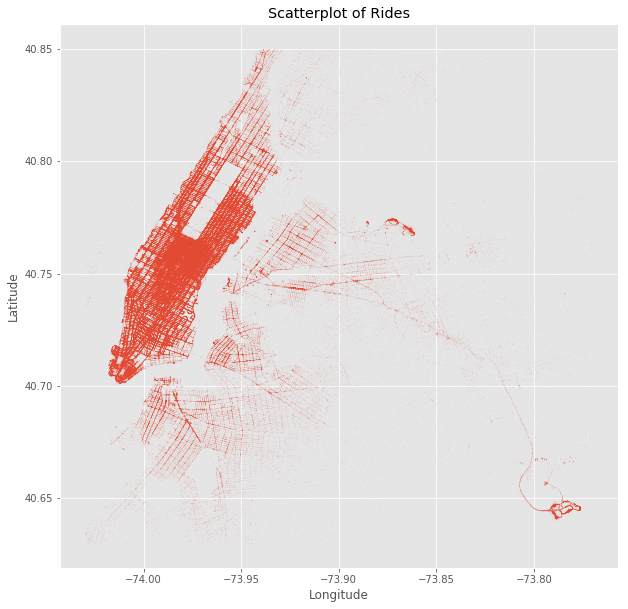

In [63]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.title('Scatterplot of Rides')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()


Next, looking at the "log_trip_duration" column, the distribution of ride duration seems to be roughly normal (especially since we already filtered out the riders that were more than 2 standard deviations away from the mean, such as the 10hr anomaly rides)

[Text(0.5, 1.0, 'Distribution of ride durations')]

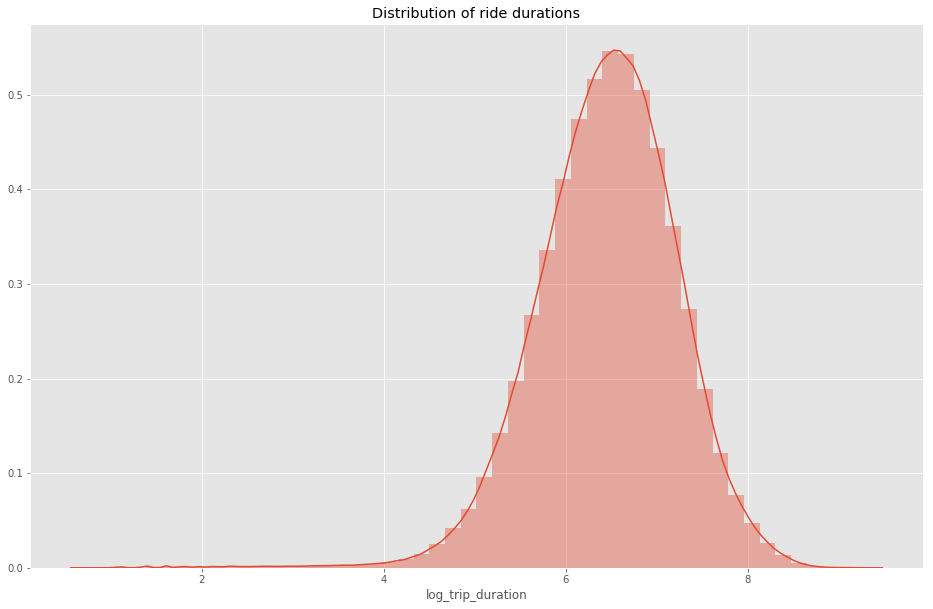

In [64]:
sns.distplot(df.log_trip_duration).set(title = 'Distribution of ride durations')

Text(0, 0.5, 'Count (rides)')

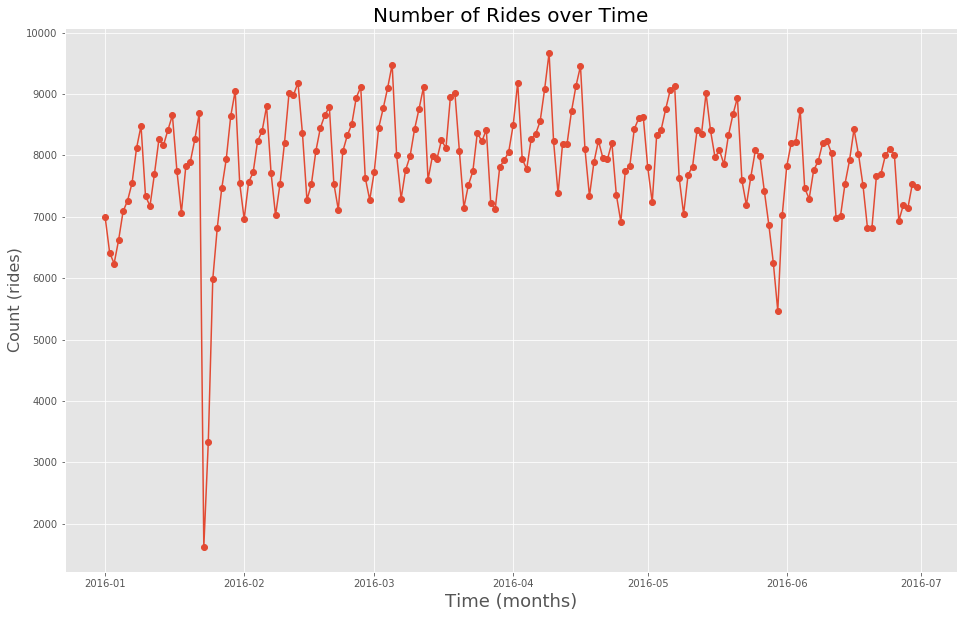

In [65]:
plt.plot(df.groupby('date').count()[['id']], 'o-')
plt.title('Number of Rides over Time', fontsize=20)
plt.xlabel('Time (months)', fontsize=18)
plt.ylabel('Count (rides)', fontsize=16)

Looking at the line plot below, we can see that there is a major dip in the number of taxi rides in late January. While this may seem like an anomaly, there are other factors that should be taken into consideration. One feasible explanation is that there was a snowstorm, and there could have easily been a driving ban for the day where the rides drop dramatically. 

Just a quick look at the data on January 23rd shows that there was snow fall of 27.3 inches, which may be enough to warrant the fact that not that many cabs were out on the road that day. 

In [66]:
df[df.date == ('2016-01-23')]['snow fall'].head()

306     27.3
586     27.3
785     27.3
1144    27.3
3443    27.3
Name: snow fall, dtype: float64

In [67]:
#creating additional time increments to plot by

df['Month'] = df['pickup_datetime'].dt.month
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek

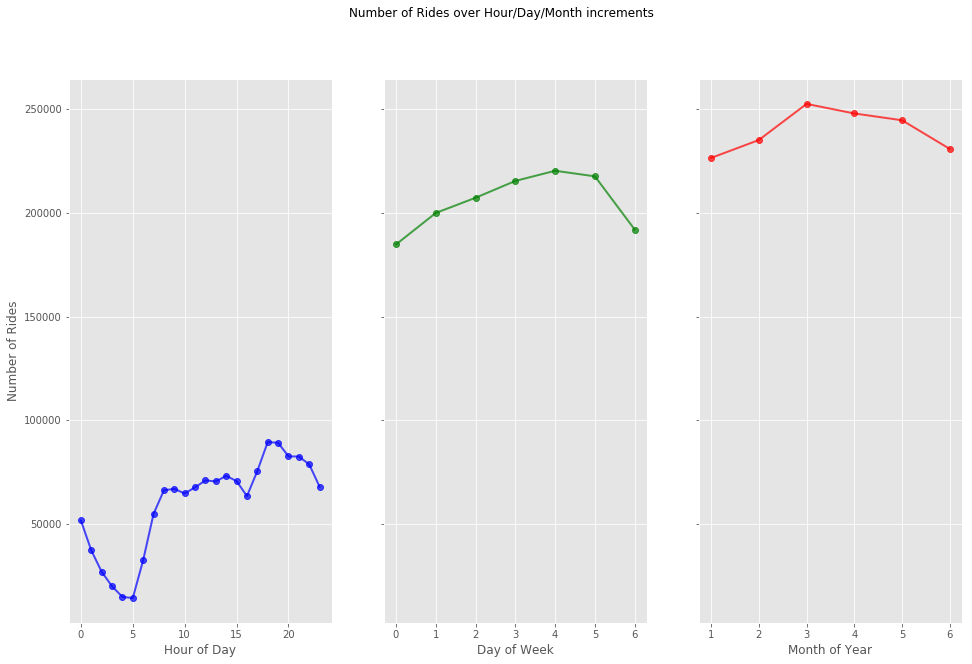

In [68]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('Hour').count()['id'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('dayofweek').count()['id'], 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('Month').count()['id'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Number of Rides')
fig.suptitle('Number of Rides over Hour/Day/Month increments')
plt.show()

The number of rides taken over the day hits a minimum at 5am and a maximum at around 6pm. 

The number of rides taken over the days of the week is at a minimum on Monday (0 on the x axis) and gradually rises to peak on Friday (4) beforeo dropping sharply on Sunday. 

Over the months of the first half of the year, january has the least number of rides, while March has the most.

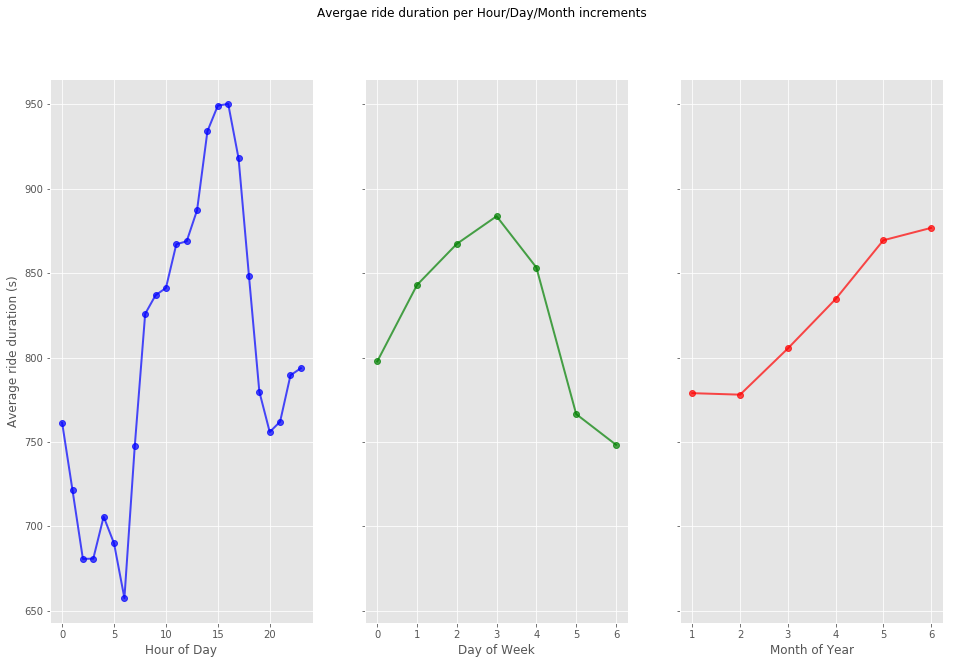

In [69]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('Hour')['trip_duration'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('dayofweek')['trip_duration'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('Month')['trip_duration'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average ride duration (s)')
fig.suptitle('Avergae ride duration per Hour/Day/Month increments')
plt.show()

During the day, the shortest trips also occur around 5am, when there are the fewest number of trips. This may be due to the lack of traffic at the hour, and the lack of need for people to go "far" in a cab at that hour. The average ride duration seems to peak at around 3pm each day, and continues to decrease in duration utnil around 8pm. Surprisingly enough, the longest average ride durations did not occur at the customary "rush hour" times of 5-6pm. 

During the week, Sunday has the lowest average ride duration followed by Saturday. Somewhat intuitively, more people have to work and have a pressing need for cabs during the weekdays, and that may be attributed to the higher taxi ride durations that gradually peak on Thursdays. On average, people are in taxis for less amount of times on weekends. 

Finally, over the coures of the first 6 months of the year, the the average ride duration is shortest during January-February, and grows almost linearly until June (when the average ride duration is at highest).

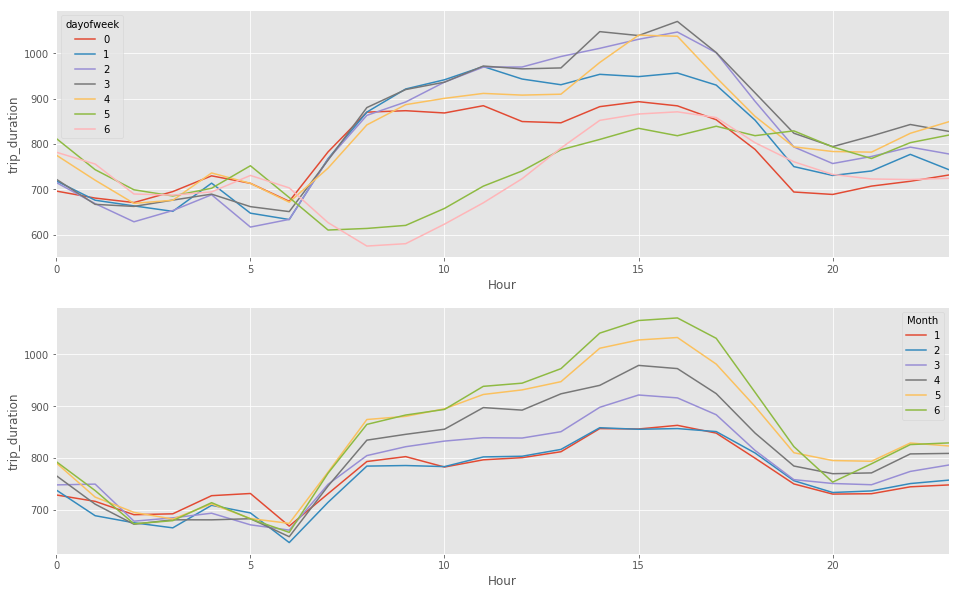

In [77]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#weekday rides plotting

weekday_rides= pd.DataFrame(df.groupby(['dayofweek', 'Hour'])['trip_duration'].mean())
weekday_rides['unit'] = 1
weekday_rides.reset_index(inplace =True)
sns.tsplot(data=weekday_rides, time  = 'Hour', unit = 'unit', condition = 'dayofweek', value= 'trip_duration', ax=ax1)

###### monthly rides plotting 

monthly_rides= pd.DataFrame(df.groupby(['Month', 'Hour'])['trip_duration'].mean())
monthly_rides['unit'] = 1
monthly_rides.reset_index(inplace =True)
sns.tsplot(data=monthly_rides, time  = 'Hour', unit = 'unit', condition = 'Month', value= 'trip_duration', ax=ax2)



The plots above reaffirm the points made from the previous two sets of line plots.

We see a noticeable decrease in average trip duration during the weekends, and we also see the highest average trip durations during June and May. 

There are also two vendors in the vendor_id section. From the barplot (subplot 1) below, we can see that there is a miniscule difference in average ride times between the two vendors. Intuitively, taxi drivers probably have a "feel" for which route to take at which time of day, and that optimizing their ride durations comes with experience. The difference of around 20 seconds seems to be almost negligeble at this scale.

The "store and forward" flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

It seems from the barplot (subplot 2) below that the average trip durations do depend on whether or not the trip was logged right away or stored and forwarded. If the taxi did not have access to the servers, it would mean that the store/forward flag status would be 1. This may imply that the taxi was farther away in range where it could not access the server to forward the information right away - also implying that the ride took longer because it was to a destination farther away.

[Text(0, 0.5, 'Average Ride Duration (s)'),
 Text(0.5, 0, 'Number of Passengers')]

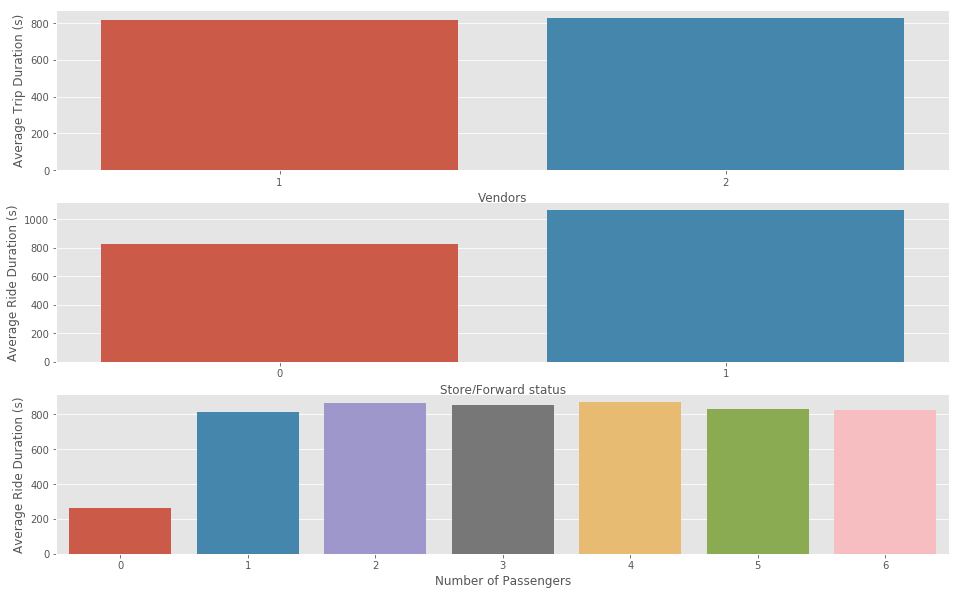

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

vendor_rides = df.groupby('vendor_id')['trip_duration'].mean()
sns.barplot(vendor_rides.index, vendor_rides.values, ax = ax1).set(xlabel = 'Vendors', ylabel = 'Average Trip Duration (s)')


store_flag =  df.groupby('store_and_fwd_flag')['trip_duration'].mean()
sns.barplot(store_flag.index, store_flag.values, ax = ax2).set(xlabel = 'Store/Forward status', ylabel = 'Average Ride Duration (s)')


num_pass = df.groupby('passenger_count')['trip_duration'].mean()
sns.barplot(num_pass.index, num_pass.values, ax = ax3).set(xlabel = 'Number of Passengers', ylabel = 'Average Ride Duration (s)')


From the last barplot (subplot 3) we can see that there are actually trips recorded with 0 passengers. This seems like an error since a taxi driver wouldn't just turn on the meter to driver somewhere and charge himself. Otherwise, for the passenger counts of 1 through 6 they all have similar average trip durations of around 800 seconds.

Unlike the popular ride sharing applications used by many today, we can assume that most people who ride taxis together are presumably going to the same destination, and the taxi does not need to make multiple stops or take a roundabout route. This may explain how having more passengers does not seem to increase the average ride duration.